Este archivo es para implementar algunos algoritmos de aprendizaje por refuerzo y aplicarlos utilizando Open AI gym.

Se van a probar los siguientes 2 entornos (environments), de acuerdo con los resultados presentados en el articulo de Diego:

Pendulum-v0 y Hopper-v2

Tareas (Puede cambiar):
1. Terminar el curso de David Silver. (Completo: 100%)
2. Implementar con table lookup. (En progreso: Ya medio funciona (por ahi un 80%))
3. Implementar con DQN. (Sin comenzar)
4. Implementar con Simglucose (Sin comenzar)
5. Implementar con el trabajo de Diego.

# Librerías

In [2]:
import gym
import time
import numpy as np
import progressbar

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense

%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Table Lookup

Pendulum-v0<br /> 
Utilizando el algoritmo de Sarsa.<br />
Está como chambón pero funciona.

In [112]:
def darIndice(pS):
    return int(round(pS, 1)*10+10)

def escogerAccion(pS1, pS2, pS3):
    num = np.random.random()
    
    if(num <= epsilon):
        ind = np.random.randint(0,41)
        return ind
    else:
        ind = np.where(tablaQ[pS1, pS2, pS3, :] == np.amax(tablaQ[pS1, pS2, pS3, :]))
        ind = ind[0]
        
        if(len(ind) > 1):
            return np.random.choice(ind)
        else:
            return ind
    
    return accion

In [153]:
envName = 'Pendulum-v0'

g = 0.9
alpha = 0.5
epsilon = 0.1 #Entre 0 y 1
maxIter = 1500000
ventana = 100
epsilonIterLimit = maxIter*0.9

tablaQ = np.ones((21,21,17,41))*-16
rewards = np.zeros(int(maxIter/10))

env = gym.make(envName)
observation = env.reset()

s1 = darIndice(observation[0])
s2 = darIndice(observation[1])
s3 = int(round(observation[2], 0) + 8)
a = escogerAccion(s1, s2, s3)

suma = 0

for i in progressbar.progressbar(range(maxIter)):
    
    if(i > maxIter-2000):
        env.render()
    
    observation, reward, done, info = env.step([(a-20)/10.0])
    observation = np.reshape(observation, (3,))
    
    s1p = darIndice(observation[0])
    s2p = darIndice(observation[1])
    s3p = int(round(observation[2], 0) + 8)
    
    ap = escogerAccion(s1p, s2p, s3p)
    
    r = reward #Por ahora
    suma+=r
    
    if(i % ventana == 0):
        rewards[int(i/ventana)] = suma/ventana
        suma = 0
    
    tablaQ[s1, s2, s3, a] = tablaQ[s1, s2, s3, a] + alpha*(r + g*tablaQ[s1p, s2p, s3p, ap] - tablaQ[s1,s2,s3,a])
    
    s1 = s1p
    s2 = s2p
    s3 = s3p
    a = ap
    
    if(i > epsilonIterLimit):
        epsilon = 0
    
env.close()

100% (1500000 of 1500000) |##############| Elapsed Time: 0:04:49 Time:  0:04:49


In [160]:
for i in progressbar.progressbar(range(2000)):
    env.render()
    
    observation, reward, done, info = env.step([(a-20)/10.0])
    observation = np.reshape(observation, (3,))
    
    s1p = darIndice(observation[0])
    s2p = darIndice(observation[1])
    s3p = int(round(observation[2], 0) + 8)
    
    ap = escogerAccion(s1p, s2p, s3p)
    
    r = reward #Por ahora
    suma+=r
    
    if(i % ventana == 0):
        rewards[int(i/ventana)] = suma/ventana
        suma = 0
    
    tablaQ[s1, s2, s3, a] = tablaQ[s1, s2, s3, a] + alpha*(r + g*tablaQ[s1p, s2p, s3p, ap] - tablaQ[s1,s2,s3,a])
    
    s1 = s1p
    s2 = s2p
    s3 = s3p
    a = ap
    
env.close()

100% (2000 of 2000) |####################| Elapsed Time: 0:00:33 Time:  0:00:33


# DQN

In [ ]:
#Creando red neuronal
def crearModelo(n1 = 10, n2 = 4):
    modelo = Sequential()
    
    modelo.add(Dense(n1, activation = 'relu', input_dim = 3))
    modelo.add(Dense(n2, activation = 'linear'))
    
    modelo.compile(loss = 'mean_squared_error', optimizer = 'sgd', metrics = 'acc')
    

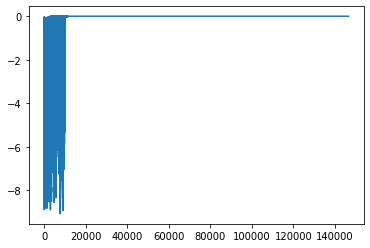

In [159]:
envName = 'Pendulum-v0'

gamma = 0.9
alpha = 0.5
epsilon = 0.1 #Entre 0 y 1
episodes = 1500
ventana = 100
epsilonIterLimit = episodes*0.9

rewards = np.zeros(int(episodes/10))

env = gym.make(envName)
observation = env.reset()

s1 = darIndice(observation[0])
s2 = darIndice(observation[1])
s3 = int(round(observation[2], 0) + 8)
a = escogerAccion(s1, s2, s3)

suma = 0

for i in progressbar.progressbar(range(episodes)):
    
    if(i > maxIter-2000):
        env.render()
    
    observation, reward, done, info = env.step([(a-20)/10.0])
    observation = np.reshape(observation, (3,))
    
    s1p = darIndice(observation[0])
    s2p = darIndice(observation[1])
    s3p = int(round(observation[2], 0) + 8)
    
    ap = escogerAccion(s1p, s2p, s3p)
    
    r = reward #Por ahora
    suma+=r
    
    if(i % ventana == 0):
        rewards[int(i/ventana)] = suma/ventana
        suma = 0
    
    target = r + gamma*tablaQ[s1p, s2p, s3p, ap]
    tablaQ[s1, s2, s3, a] = tablaQ[s1, s2, s3, a] + alpha*(target - tablaQ[s1,s2,s3,a])
    
    s1 = s1p
    s2 = s2p
    s3 = s3p
    a = ap
    
    if(i > epsilonIterLimit):
        epsilon = 0
    
env.close()

In [6]:
import gym
env = gym.make('Pendulum-v0')
for i_episode in range(20):
    observation = env.reset()
    for t in range(10):
        env.render()
        print(observation)
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()

[-0.35483207  0.93493005 -0.92173004]
[-0.34984433  0.93680785 -0.10659038]
[-0.36694778  0.93024154  0.36641711]
[-0.40403398  0.91474398  0.80393496]
[-0.46195516  0.88690328  1.28551763]
[-0.55099042  0.83451157  2.06704374]
[-0.6599625   0.75129854  2.74436492]
[-0.77344545  0.63386287  3.26980124]
[-0.87460842  0.48482998  3.60737306]
[-0.9538742   0.30020663  4.02519005]
[0.9990358  0.043903   0.37534164]
[0.99732398 0.07310874 0.58513808]
[0.99542222 0.09557517 0.45094514]
[0.99209136 0.12551783 0.60256984]
[0.9860903  0.16621046 0.82271283]
[0.97665948 0.21479351 0.98989981]
[0.96219796 0.27235103 1.18710364]
[0.93752037 0.3479304  1.59054173]
[0.9036082  0.42835992 1.7462857 ]
[0.85761939 0.51428493 1.94993394]
[-0.82841116  0.56012048 -0.95977252]
[-0.80765589  0.58965411 -0.72198556]
[-0.80620443  0.59163706 -0.04914811]
[-0.82611872  0.5634961   0.68952453]
[-0.85472284  0.51908465  1.05664026]
[-0.88873854  0.45841445  1.39138678]
[-0.92369113  0.38313795  1.66038466]
[-0.

In [5]:
print(env.observation_space)
print(env.action_space)

Box(3,)
Box(1,)


In [4]:
print(env.observation_space.high)
print(env.observation_space.low)

[1. 1. 8.]
[-1. -1. -8.]


In [43]:
np.random.random()

0.3578890399283928

In [50]:
np.random.randint(0,6)

0

In [59]:
test = np.array([10,22,50,-1,50])

In [67]:
test3 = np.where(test == np.amax(test))

In [69]:
len(test3[0])

2

In [140]:
rewards[10/10]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices